In [1]:
SLURM_MODE = False

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
if not SLURM_MODE:
    %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm.notebook import tqdm
import os
sns.set()
import functools
import pickle
import itertools
import sys
from enum import Enum, auto
from dataclasses import dataclass

In [2]:
class Mirroring(Enum):
    none = 'none'
    initial = 'initial'
    epoch = 'epoch'
    

architectures = [['simple', [32 * 32 * 3, 1024, 10]], ['simple', [32 * 32 * 3, 512, 512, 512, 10]], ['skip', [32 * 32 * 3, 10, [512]]], ['skip', [32 * 32 * 3, 10, [1024, 512]]]]

experiments = list(itertools.product(*[
    architectures,
    [['pepita', 0.01], ['fa', 0.001]],
    ['sgd', 'mom'], # update algorithms
    list(Mirroring), # mirroring
    list(range(3))]))# run number


@dataclass
class Exp:
    architecture: str
    layers = list
    learning_algo: str
    learning_rate: float
    update_algo: str
    mirroring: Mirroring
    run: int
    
    def __init__(self, i):
        
        e = experiments[i]
        
        self.architecture = e[0][0]
        self.layers = e[0][1]
        self.learning_algo = e[1][0]
        self.learning_rate = e[1][1]
        self.update_algo = e[2]
        self.mirroring = e[3]
        self.run = e[4]
        
        self.exp_dir = f'/home/cpsc490_ac2788/CPSC490/experiments/set3/exp{i // 3}'
        
        if not os.path.exists(self.exp_dir):
            os.makedirs(self.exp_dir, exist_ok=True)
            self.log(os.path.join(self.exp_dir, 'exp_parameters.txt'))
            
        self.exp_run_dir = os.path.join(self.exp_dir, f'run{self.run}')

        os.makedirs(self.exp_run_dir, exist_ok=True)

        self.exp_log = os.path.join(self.exp_run_dir, 'exp_parameters.txt')
        self.exp_stat_file = os.path.join(self.exp_run_dir, 'net_statistics.pkl')
        self.fig_file = os.path.join(self.exp_run_dir, 'fig.png')
        
        self.log(self.exp_log)
    
    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        out = ''
        obj_vars = vars(self)
        for k in obj_vars:
            if k == 'mirroring':
                out += f'{k} : {obj_vars[k].value}\n'
            else:
                out += f'{k} : {obj_vars[k]}\n'
        return out
    
    def log(self, path):
        with open(path, 'w') as f:
            f.write(self.__repr__())

In [3]:
exp_id = int(sys.argv[1]) if SLURM_MODE else 0

exp = Exp(exp_id)

In [4]:
batch_size = 64

transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                torchvision.transforms.Lambda(lambda x: x.flatten())])


train_dataset = torchvision.datasets.CIFAR10('/home/cpsc490_ac2788/CPSC490/experiments/cifar10/', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10('/home/cpsc490_ac2788/CPSC490/experiments/cifar10/', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
colors = list(mcolors.TABLEAU_COLORS)

def setup_axis(ax, num_epochs, title, data_shape):
    ax.set_xlim(0, num_epochs - 1)
    ax.set_title(title)
    
    d = np.empty(data_shape)
    d[:] = np.nan
    data = {}
    for s in ['mean', 'std', 'max', 'min']:
        data[s] = d.copy()
    plot = []
    legend_elements = []
    for i in range(data_shape[1]):
        label = f'Layer {i}'
        mean_line = ax.plot(data['mean'][:,i], label=label, c=colors[i])[0]
        max_line = ax.plot(data['max'][:,i], c=colors[i], dashes=[6,2])[0]
        min_line = ax.plot(data['min'][:,i], c=colors[i], dashes=[6,2])[0]
        plot.append((mean_line, max_line, min_line))
        legend_elements.append(Patch(facecolor=colors[i], label=label))

    ax.legend(handles=legend_elements, loc='center right')

    
    return data, plot

def log_data(data, new_data, epoch, simple_avg=False):
    data['mean'][epoch] = [torch.mean(layer).cpu() for layer in new_data]
    data['std'][epoch] = [torch.std(layer).cpu() for layer in new_data]
    data['max'][epoch] = [torch.max(layer).cpu() for layer in new_data]
    data['min'][epoch] = [torch.min(layer).cpu() for layer in new_data]

def set_axis_data(ax, p, data, num_epochs, simple_avg=False):
    ax.collections.clear()

    for i, line_set in enumerate(p):
        if not simple_avg:
            for j, name in enumerate(['mean', 'max', 'min']):
                line_set[j].set_ydata(data[name][:,i])
            ax.fill_between(range(num_epochs), data['mean'][:,i] - data['std'][:,i], data['mean'][:,i] + data['std'][:,i], color=colors[i], alpha=0.2)
        else:
            line_set[0].set_ydata(data['mean'][:,i])

    ax.relim()
    ax.autoscale()
    ax.set_xlim(0, num_epochs - 1)

In [6]:
def train(net, train_loader, num_epochs, test_loader, mirroring):
    
    criterion = nn.CrossEntropyLoss()
    
    plt.close('all')
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    
    if not SLURM_MODE:
        hfig = display(fig, display_id=True)
    
    weights, weights_plot = setup_axis(axes[0], num_epochs, "Weights", (num_epochs, len(net.weights)))
    b_weights, b_weights_plot = setup_axis(axes[1], num_epochs, "B Matrix", (num_epochs, len(net.weights)))
    activations, activations_plot = setup_axis(axes[2], num_epochs, "Activations", (num_epochs, len(net.weights)))
    deltas, deltas_plot = setup_axis(axes[3], num_epochs, "Matrix Deltas", (num_epochs, len(net.weights) + 1))
    accuracies, accuracies_plot = setup_axis(axes[4], num_epochs, "Accuracy", (num_epochs, 1))
    
    with torch.no_grad():

        net.mirror(0 if mirroring == Mirroring.none else 2)
        for epoch in tqdm(range(num_epochs), desc="Epoch", disable=SLURM_MODE):
            if SLURM_MODE:
                print(f'Training epoch {epoch}')

            with tqdm(total=len(train_loader) + len(test_loader), leave=False, desc="Batch", disable=SLURM_MODE) as pbar:
                running_loss = 0

                for batch_idx, (data, targets) in enumerate(train_loader):

                    if torch.cuda.is_available():
                        data = data.cuda()
                        targets = targets.cuda()
                        
                    y = net(data, True, True)

                    one_hot = nn.functional.one_hot(targets, num_classes=10)

                    net.update(data, y - one_hot)

                    running_loss += criterion(y, targets) / data.shape[0]
                    pbar.update(1)

                epoch_deltas = net.mirror(1 if mirroring == Mirroring.epoch else 0)
                net.decay(epoch)

                log_data(weights, net.weights, epoch)
                log_data(b_weights, net.B_weights, epoch)
                log_data(activations, net.get_activations(), epoch)
                log_data(deltas, torch.unsqueeze(epoch_deltas, 1), epoch)

                test_means = torch.zeros(len(test_loader))

                for batch_idx, (data, targets) in enumerate(test_loader):

                    if torch.cuda.is_available():
                        data = data.to('cuda')
                        targets = targets.to('cuda')

                    test_means[batch_idx] = torch.mean((targets == torch.argmax(net(data), axis=1)).float())
                    pbar.update(1)
                    
                log_data(accuracies, torch.unsqueeze(test_means, 0), epoch)

                set_axis_data(axes[0], weights_plot, weights, num_epochs)
                set_axis_data(axes[1], b_weights_plot, b_weights, num_epochs)
                set_axis_data(axes[2], activations_plot, activations, num_epochs)
                set_axis_data(axes[3], deltas_plot, deltas, num_epochs, simple_avg=True)
                set_axis_data(axes[4], accuracies_plot, accuracies, num_epochs, simple_avg=True)

                fig.canvas.draw()
                
                if not SLURM_MODE:
                    hfig.update(fig)
                
            with open(exp.exp_stat_file, 'wb') as f:
                pickle.dump({'weights': weights, 'b_weights': b_weights, 'activations': activations, 'deltas': deltas, 'accuracies': accuracies}, f)
    
    if SLURM_MODE:
        print('Finished Training')

In [15]:
def generate_layer(in_size, out_size, final_layer):
    w = nn.Linear(in_size, out_size, bias=False)
    w_limit = np.sqrt(6.0 / in_size)
    
    torch.nn.init.uniform_(w.weight, a=-w_limit, b=w_limit)
        
    return nn.Sequential(w, nn.ReLU()) if not final_layer else nn.Sequential(w)


def generate_b_layer(in_size, out_size, n):
    w = nn.Linear(in_size, out_size, bias=False)
    w_limit = np.sqrt(6.0 / (32 * 32 * 3)) # TODO: hardcoded 32 * 32 * 3, but really should be set per dataset
    w_limit *= 0.05
    # w_limit = np.power(w_limit, 1/n)
    
    torch.nn.init.uniform_(w.weight, a=-w_limit, b=w_limit)
    
    return w

def collect_activations(model, l):
    def hook(self, input, output):
        model.activations[l] = output.detach()
    return hook

def angle_between(A, B):
    flat_A = A.flatten()
    normalized_flat_A = flat_A / torch.linalg.norm(flat_A)

    flat_B = B.flatten()
    normalized_flat_B = flat_B / torch.linalg.norm(flat_B)

    return (180.0 / torch.pi) * torch.arccos(torch.clip(torch.dot(normalized_flat_A, normalized_flat_B), -1.0, 1.0))

class FCNet(nn.Module):

    @torch.no_grad()
    def __init__(self, layer_sizes, learning_rate=0.01, decay_epochs=[60, 90], learning_algo='pepita', update_algo='sgd', dropout=0.9, final_layer=True, num_bs=None):
        super(FCNet, self).__init__()
        
        self.learning_rate = learning_rate
        self.decay_epochs = decay_epochs
        
        self.learning_algo = learning_algo
        self.update = self.__pepita_update if learning_algo == 'pepita' else self.__fa_update
        
        self.layer_sizes = layer_sizes

        self.layers_list = [generate_layer(in_size, out_size, i == (len(layer_sizes) - 2)) for i, (in_size, out_size) in enumerate(zip(layer_sizes, layer_sizes[1:]))]
        self.layers = nn.Sequential(*self.layers_list)
        self.output_activation = nn.Softmax(dim=1) if final_layer else nn.ReLU()
        
        self.weights = [layer[0].weight for layer in self.layers]
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
        
        b_sizes = list(reversed(list(zip(layer_sizes, layer_sizes[1:]))))
        num_b_layers = num_bs if num_bs is not None else len(b_sizes)
        self.B = [generate_b_layer(out_size, in_size, num_b_layers) for in_size, out_size in b_sizes]
        self.B_layers = nn.Sequential(*self.B)
        self.B_weights = [b.weight for b in self.B]
        
        self.update_algo = update_algo
        if self.update_algo == 'mom':
            self.gamma = 0.9
            self.prev_update = [torch.zeros(weight.shape).cuda() for weight in self.weights]
            
        self.dropout = dropout
        self.do_masks = [None] * len(self.layers_list)
        
        if torch.cuda.is_available():
            self.cuda()
        
    @torch.no_grad()
    def get_activations(self):
        try:
            return [activations.clone() for activations in self.activations]
        except:
            return None
        
    def final_layer(self, i):
        return i == len(self.layers) - 1
        
    @torch.no_grad()        
    def forward(self, x, mask=False, new_masks=False):
        for l, layer in enumerate(self.layers_list):
            x = layer(x)
            if mask and not self.final_layer(l):
                if new_masks:
                    dropout_mask = torch.bernoulli(torch.ones(x.shape) * self.dropout).cuda() / self.dropout
                    self.do_masks[l] = dropout_mask
                else:
                    dropout_mask = self.do_masks[l]
                x *= dropout_mask
        return self.output_activation(x)

    @torch.no_grad()
    def decay(self, epoch):
        if epoch in self.decay_epochs:
            self.learning_rate *= 0.1
            
    @torch.no_grad()
    def __pepita_update(self, x, e, first_block=True, last_block=True):

        if first_block:
            hl_err = x + self.B_layers(e)
        else:
            hl_err = x

        forward_activations = self.get_activations()
        modulated_forward = self.forward(hl_err, True)
        modulated_activations = self.get_activations()
        
        for l, layer in enumerate(self.layers):
            if self.final_layer(l) and last_block:
                dwl = -e.T @ (modulated_activations[l - 1] if l != 0 else x)
            else:
                dwl = -(forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else hl_err)
            
            self.__weight_update(l, dwl)
        
        return modulated_forward
        
            
    @torch.no_grad() #updates necessry here: backward cycle through network to pass dl back, forward activatoins of preovios to serve as x for the current
    def __fa_update(self, x, e, first_block=True, last_block=True):
        
        forward_activations = self.get_activations()
        dl = e
        for bl, wl in enumerate(reversed(range(len(self.weights)))):
            
            yl = forward_activations[wl - 1] if wl != 0 else x
            dwl = -(dl.T @ yl)
            
            self.__weight_update(wl, dwl)
            
            dl = self.B_layers[bl](dl) * torch.relu(yl)
            
        return dl
            
    def __weight_update(self, l, dwl):
        w_update = self.learning_rate * dwl / batch_size
        if self.update_algo == 'mom':
            self.prev_update[l] = (self.gamma * self.prev_update[l]) + w_update
            w_update = self.prev_update[l]

        self.layers[l][0].weight += w_update
            
    
    @torch.no_grad()
    def mirror(self, n_reps=1, get_overall_delta=True):
        deltas = [] #only gets the last reps deltas
        
        if get_overall_delta:
            overall_weight_angle = torch.eye(self.layers[0][0].weight.shape[1]).cuda()
        for l, (layer, b_layer) in enumerate(zip(self.layers, reversed(self.B_layers))):
            for _ in range(n_reps):
                noise = 0.1 * (torch.randn(batch_size, layer[0].weight.shape[1]).cuda())
                dl = noise - torch.mean(noise)
                yl1 = self.layers[l](noise)
                if self.final_layer(l):
                    yl1 = torch.relu(yl1)
                dl1 = yl1 - torch.mean(yl1)
                b_layer.weight *= 0.5
                b_layer.weight += 0.1 * (dl.T @ dl1) #(noise.T @ yl1)
                
            if get_overall_delta:
                overall_weight_angle = layer[0](overall_weight_angle)

            deltas.append(angle_between(layer[0].weight.T, b_layer.weight))
         
        if get_overall_delta:
            deltas.append(angle_between(overall_weight_angle.T, self.B_layers(torch.eye(self.B_layers[0].weight.shape[1]).cuda())))
            
        return torch.tensor(deltas)

In [16]:
class FCSkipNet(nn.Module):

    @torch.no_grad()
    def __init__(self, input_size, output_size, block_sizes, block_depth=3, learning_rate=0.01, decay_epochs=[60, 90], learning_algo='pepita', update_algo='sgd', dropout=0.9):
        super(FCSkipNet, self).__init__()
        
        num_bs = (len(block_sizes) * 4) + 1
        
        def generate_FCNet(layer_sizes, final_layer):
            return FCNet(layer_sizes, learning_rate=learning_rate, decay_epochs=decay_epochs, learning_algo=learning_algo, update_algo=update_algo, dropout=dropout, final_layer=False, num_bs=num_bs)
        
        self.blocks = [generate_FCNet([block] * (block_depth + 1), False) for block in block_sizes]
        self.dim_maps = [generate_FCNet([input_size, block_sizes[0]], False)]
        self.dim_maps += ([generate_FCNet([in_size, out_size], False) for in_size, out_size in zip(block_sizes, block_sizes[1:])])
        self.dim_maps.append(generate_FCNet([block_sizes[-1], output_size], True))
        
        self.components = []
        for dim_map, block in zip(self.dim_maps, self.blocks):
            self.components += [dim_map, block]
        self.components += [self.dim_maps[-1]]
        
        self.layers = []
        self.weights = []
        self.B_weights = []
        self.B = []
        
        for component in self.components:
            self.layers += component.layers
            self.weights += component.weights
            self.B += component.B
            self.B_weights += component.B_weights
        
        self.B_layers = nn.Sequential(*reversed(self.B))
        
        self.learning_algo = learning_algo
        self.update = self.__pepita_update if learning_algo == 'pepita' else self.__fa_update
        
    def get_activations(self):
        activations = []
        for component in self.components:
            activations += component.get_activations()
        return activations

        
    def __repr__(self):
        res = ''
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            res += f'Dim Map {b}\n'
            res += dim_map.__repr__()
            res += '\n'
            res += f'Block {b}\n'
            res += block.__repr__() + '\n'
        res += self.dim_maps[-1].__repr__()
        return res
    
    def forward(self, x, mask=False, new_masks=False):
        
        in_x = x
        x = 0
        
        if self.learning_algo == 'fa':
            self.inputs = []
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            if self.learning_algo == 'fa':
                self.inputs.append(in_x + x)
            in_x = dim_map(in_x + x, mask, new_masks)
            if self.learning_algo == 'fa':
                self.inputs.append(in_x)
            x = block(in_x, mask, new_masks)
            
        if self.learning_algo == 'fa':
                self.inputs.append(in_x + x)
        return self.dim_maps[-1](in_x + x, mask, new_masks)
    
    def __pepita_update(self, x, e):
        
        in_hl_err = x + self.B_layers(e)
        hl_err = 0
        
        for b, (dim_map, block) in enumerate(zip(self.dim_maps, self.blocks)):
            in_hl_err = dim_map.update(in_hl_err + hl_err, None, False, False)
            hl_err = block.update(in_hl_err, None, False, False)
            
        self.dim_maps[-1].update(in_hl_err + hl_err, e, False, True)
        
    def __fa_update(self, x, e):
        dl = e
        for c, component in enumerate(reversed(self.components)):
            dl = component.update(self.inputs[-(1 + c)], dl, False, False)
        
        
    def mirror(self, nreps=1):
        deltas = []
        for component in self.components:
            deltas.append(component.mirror(nreps, False))
        
        overall_weight_angle = torch.eye(self.layers[0][0].weight.shape[1]).cuda()
        for layer in self.layers:
            overall_weight_angle = layer[0](overall_weight_angle)
        
        deltas.append(angle_between(overall_weight_angle.T, self.B_layers(torch.eye(self.B_layers[0].weight.shape[1]).cuda())).cpu().unsqueeze(0))

        return torch.cat(deltas)
            
    def decay(self, epoch):
        for component in self.components:
            component.decay(epoch)

In [17]:
if exp.architecture == 'simple':
    net = FCNet(exp.layers, learning_algo=exp.learning_algo, learning_rate=exp.learning_rate, update_algo=exp.update_algo)
else:
    net = FCSkipNet(exp.layers[0], exp.layers[1], exp.layers[2], learning_algo=exp.learning_algo, learning_rate=exp.learning_rate, update_algo=exp.update_algo)

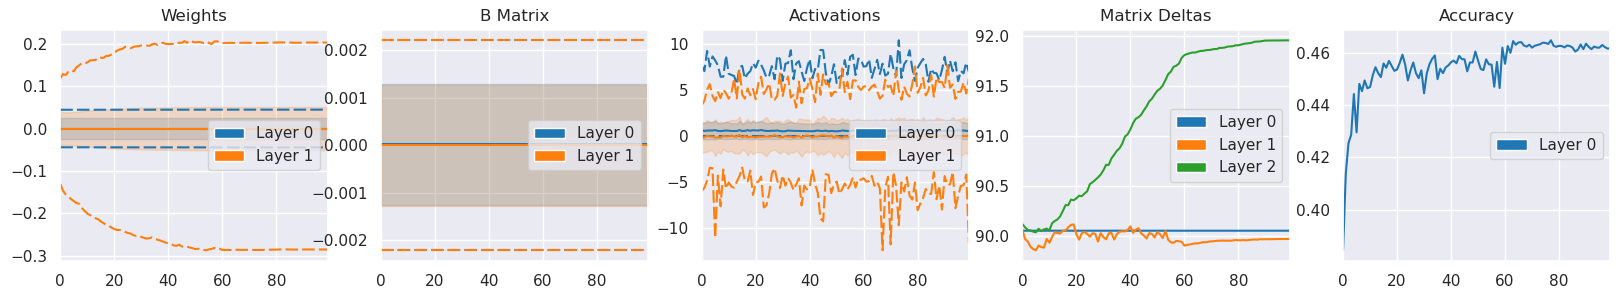

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

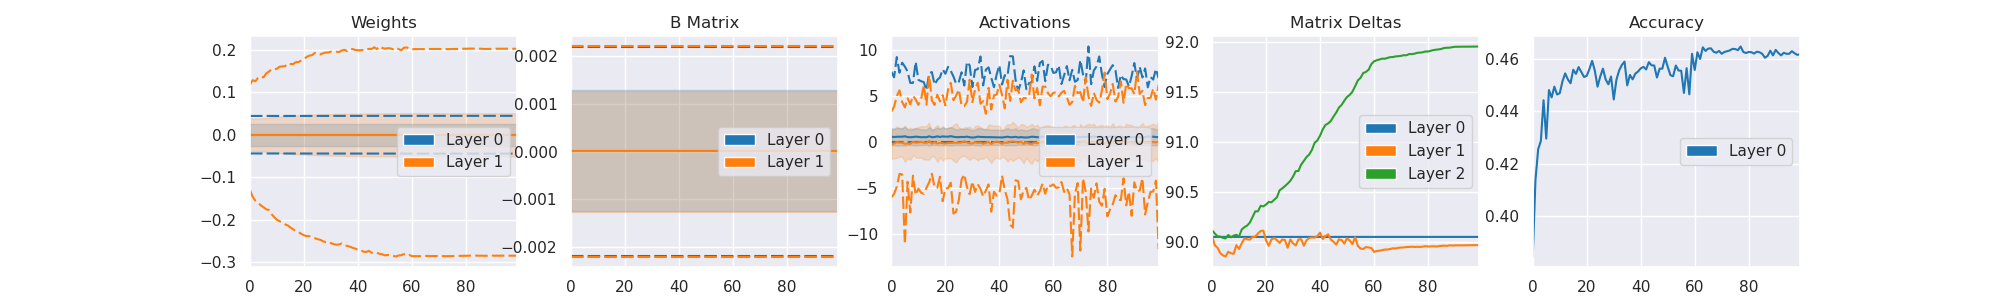

In [18]:
train(net, train_loader, 100, test_loader, mirroring=Mirroring.none)